# Data pre-processing

Aggregate monthly data and produce new features from raw data.

1. sum and standard deviation of counts (for each item-shop pair, each item, and each shop) by month
1. price, revenue, growth between median montly item price compared to overall median item price
1. lag (some of) the above features by 1,2,3 and/or 12 months

## Load raw data

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import os
import pickle
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = '../Data/'
INTERM_RES_FOLDER = "../Intermediary results"

In [3]:
sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items    = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cat = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops    = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test     = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

## Repair oddities

See EDA. Duplicate shops with different ID's and price outlier.

In [4]:
sales.loc[sales.shop_id == 10, "shop_id"] = 11
sales.loc[sales.shop_id == 40] == 39
sales.loc[sales.shop_id == 0, "shop_id"] = 57
sales.loc[sales.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 10, "shop_id"] = 11
test.loc[test.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 1, "shop_id"] = 58
shops = shops[~shops.shop_id.isin([10,0,1])]
sales.drop(index=1163158, inplace=True)# price outlier, single item
sales.loc[sales.item_price < 0, "item_price"] = 1249# based on same item, same day

## Extract information from text data

In [5]:
shops["city_name"] = shops.shop_name.apply(lambda x: x.split(" ")[0])
le = preprocessing.LabelEncoder()
shops["city"] = le.fit_transform(shops["city_name"])

In [6]:
item_cat["splitlist"] = item_cat.item_category_name.apply(lambda x: x.split("-"))
item_cat["metacat_name"] = item_cat.splitlist.apply(lambda x: x[0].strip())
item_cat["subcat_name"]  = item_cat.splitlist.apply(lambda x: x[1] if len(x) > 1 else x[0])
item_cat.drop(columns="splitlist", inplace=True)
item_cat["metacat"] = le.fit_transform(item_cat["metacat_name"])
item_cat["subcat"] = le.fit_transform(item_cat["subcat_name"])

0.4825444565857249


<BarContainer object of 25 artists>

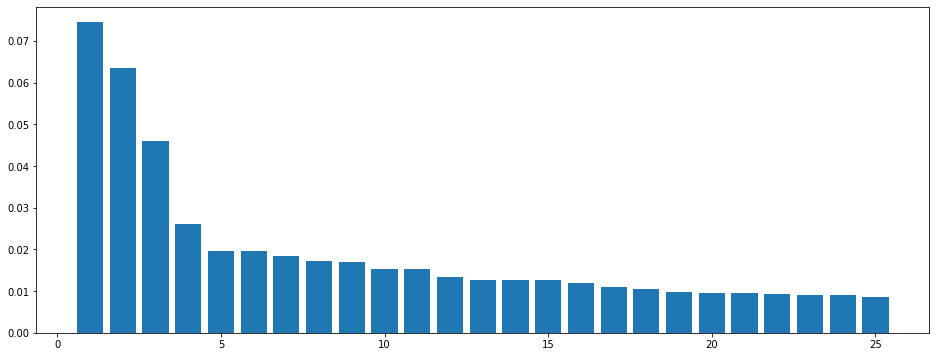

In [8]:
items["item_name_clean"] = items["item_name"].apply(lambda x: x.lower())
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: re.sub(r'\W+',' ',x))
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: re.sub('  ',' ',x))
items["item_name_clean"] = items["item_name_clean"].apply(lambda x: x.strip())

tfidf = TfidfVectorizer(lowercase=False, max_features=250).fit_transform(items.item_name_clean)
svd = TruncatedSVD(n_components=25).fit(tfidf)

print("Explained variance:" svd.explained_variance_ratio_.sum())
plt.figure(figsize=(16, 6))
plt.bar(x=range(1,26), height=svd.explained_variance_ratio_)

In [10]:
svd = TruncatedSVD(n_components=5).fit(tfidf)
word2num = svd.transform(tfidf)

for i in range(4):
    items["item_name2num_"+str(i+1)] = word2num[:,i]

In [11]:
print("Fraction of items without information added:")
print(items.loc[(items.item_name2num_1 == 0) & (items.item_name2num_2 == 0) &
                (items.item_name2num_3 == 0) & (items.item_name2num_4 == 0)].shape[0]/items.shape[0])
items.head(5)

Fraction of items without information added:
0.12404149751917005


,item_name,item_id,item_category_id,item_name_clean,item_name2num_1,item_name2num_2,item_name2num_3,item_name2num_4
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,во власти наваждения пласт d,0.000000,0.00000,0.000000,0.000000
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,abbyy finereader 12 professional edition full ...,0.003944,0.00536,0.586374,-0.083372
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,в лучах славы unv d,0.000000,0.00000,0.000000,0.000000
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,голубая волна univ d,0.000000,0.00000,0.000000,0.000000
4,***КОРОБКА (СТЕКЛО) D,4,40,коробка стекло d,0.000000,0.00000,0.000000,0.000000


## Add base features

In [ ]:
sales["item_rev_day"] = sales["item_cnt_day"] * sales["item_price"]
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")
sales["month"] = sales["date"].dt.month
sales["item_price_med_all"] = sales.groupby("item_id").item_price.transform(np.median)
sales["item_price_med"] = sales.groupby(["date_block_num", "item_id"]).item_price.transform(np.median)
assert sales.item_price_med_all.min() > 0
sales["item_price_rel"] = (sales["item_price_med"] - sales["item_price_med_all"]) / sales["item_price_med_all"]

In [ ]:
map_item_cat = items.loc[:, ["item_id", "item_category_id"]].drop_duplicates()
map_cat = item_cat.loc[:, ["item_category_id", "metacat", "subcat"]].drop_duplicates()
map_item_cat = map_item_cat.merge(map_cat, how="left", on="item_category_id")
map_shop = shops.loc[:, ["shop_id", "city"]].drop_duplicates()

sales = sales.merge(map_item_cat, how="left", on="item_id")
sales = sales.merge(map_shop, how="left", on="shop_id")

In [ ]:
# downcast to save space
for c in ["item_price","item_rev_day","item_price_med","item_price_rel","item_price_med_all"]:
    sales[c] = pd.to_numeric(sales[c], downcast="float")

for c in ["date_block_num","shop_id","item_id","item_cnt_day","month","item_category_id","metacat","subcat","city"]:
    sales[c] = pd.to_numeric(sales[c], downcast="integer")
sales.dtypes

## Complete shop_id x item_id combinations in each month

In [ ]:
month_blocks = sales.date_block_num.unique()
grid = []
for m in month_blocks:
    shop_ids = sales.loc[sales.date_block_num == m].shop_id.unique()
    item_ids = sales.loc[sales.date_block_num == m].item_id.unique()
    grid.append(np.array(list(product(*[shop_ids, item_ids, [m]])), dtype="int32"))
    
test["date_block_num"] = np.int8(34)
grid.append(test.drop(columns="ID"))

grid = pd.DataFrame(np.vstack(grid), columns=["shop_id", "item_id", "date_block_num"], dtype=np.int32)

In [ ]:
# merge other features: median revenue (per item and globally), relative revenue, month
map_price_med_all = sales.loc[:,["item_id","item_price_med_all"]].drop_duplicates()
map_price = sales.loc[:,["date_block_num","item_id","item_price_med","item_price_rel"]].drop_duplicates()
map_month = sales.loc[:,["date_block_num","month"]].drop_duplicates()
grid = grid.merge(map_price_med_all, how="left", on="item_id")
grid = grid.merge(map_price, how="left", on=["date_block_num","item_id"])
grid = grid.merge(map_month, how="left", on="date_block_num")
grid.month.fillna(11, inplace=True)

del map_price_med_all,map_price,map_month

In [ ]:
# add item categories
grid = grid.merge(map_item_cat, how="left", on="item_id")
grid = grid.merge(map_shop, how="left", on="shop_id")

In [ ]:
# add time-since-first-sale for each item
grid["since_first"] = 0
found_first = {}
# grid has date_block_num sorted in ascending order
assert all(grid.date_block_num.diff().drop(index=0) >= 0)

for index,row in grid.iterrows():
    if not row.item_id in found_first:
        found_first[row.item_id] = row.date_block_num
    else:
        grid.at[index,"since_first"] = row.date_block_num - found_first[row.item_id]

In [ ]:
# add time-since-first-sale for each item in each shop
grid["shop_since_first"] = 0
found_first = {}

for index,row in grid.iterrows():
    itemshop = "{} {}".format(row.item_id,row.shop_id)
    if not itemshop in found_first:
        found_first[itemshop] = row.date_block_num
    else:
        grid.at[index,"shop_since_first"] = row.date_block_num - found_first[itemshop]

In [ ]:
grid.dtypes

In [ ]:
grid["month"] = pd.to_numeric(grid["month"], downcast="integer")

In [ ]:
for c in grid.columns:
    if "int" in grid[c].dtype.name:
        grid[c] = pd.to_numeric(grid[c], downcast="integer")
    else:
        grid[c] = pd.to_numeric(grid[c], downcast="float")
grid.dtypes

In [ ]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-grid"), "wb") as f:
    pickle.dump(grid, f)

In [ ]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-grid"), "rb") as f:
    grid = pickle.load(f)

## Add aggregate features

This is equivalent to out-of-fold mean encodings.

In [ ]:
# monthly volume and its standard deviation for each item in each shop
gp = sales.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).agg({"item_cnt_day": ["sum","std"]})
# flatten multi-index
gp.columns = [level1+level2 for level1,level2 in gp.columns.to_native_types()]
gp.rename(columns={"item_cnt_daysum": "item_cnt_month",
                   "item_cnt_daystd": "itemshop_sd"}, inplace=True)
sales_all = grid.merge(gp, how="left", on=["shop_id", "item_id", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume and its standard deviation for each shop
gp = sales.groupby(["shop_id", "date_block_num"], as_index=False).agg({"item_cnt_day": ["sum","std"]})
# flatten multi-index
gp.columns = [level1+level2 for level1,level2 in gp.columns.to_native_types()]
gp.rename(columns={"item_cnt_daysum": "shop_agg", "item_cnt_daystd": "shop_sd"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["shop_id", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume and its standard deviation for each item
gp = sales.groupby(["item_id", "date_block_num"], as_index=False).agg({"item_cnt_day": ["sum","std"]})
gp.columns = [level1+level2 for level1,level2 in gp.columns.to_native_types()]
gp.rename(columns={"item_cnt_daysum": "item_agg", "item_cnt_daystd": "item_sd"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["item_id", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume and its standard deviation for each sub-category in each shop
gp = sales.groupby(["shop_id", "subcat", "date_block_num"], as_index=False).agg({"item_cnt_day": ["sum","std"]})
gp.columns = [level1+level2 for level1,level2 in gp.columns.to_native_types()]
gp.rename(columns={"item_cnt_daysum": "shopsubcat_agg", "item_cnt_daystd": "shopsubcat_sd"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["shop_id", "subcat", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each category id in each shop
gp = sales.groupby(["shop_id", "item_category_id", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "shopcat_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["shop_id", "item_category_id", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each meta-category in each shop
gp = sales.groupby(["shop_id", "metacat", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "shopmetacat_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["shop_id", "metacat", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each category_id
gp = sales.groupby(["item_category_id", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "cat_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["item_category_id", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each meta-category
gp = sales.groupby(["metacat", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "metacat_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["metacat", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each sub-category
gp = sales.groupby(["subcat", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "subcat_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["subcat", "date_block_num"]).fillna(0)

In [ ]:
# montly volume for each item in each city
gp = sales.groupby(["item_id", "city", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "itemcity_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["item_id", "city", "date_block_num"]).fillna(0)

In [ ]:
# monthly volume for each sub-category in each city
gp = sales.groupby(["subcat", "city", "date_block_num"], as_index=False).agg({"item_cnt_day": "sum"})
gp.rename(columns={"item_cnt_day": "subcatcity_agg"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["subcat", "city", "date_block_num"]).fillna(0)

In [ ]:
# monthly revenue for each item in each shop
gp = sales.groupby(["item_id","shop_id","date_block_num"], as_index=False).agg({"item_rev_day":"sum"})
gp.rename(columns={"item_rev_day": "item_rev_month"}, inplace=True)
sales_all = sales_all.merge(gp, how="left", on=["item_id","shop_id","date_block_num"]).fillna(0)

In [ ]:
# reduce size in memory: downcast
cols_int = ["item_cnt_month","shop_agg","item_agg","shopsubcat_agg","shopcat_agg","shopmetacat_agg","cat_agg",
            "metacat_agg","subcat_agg","itemcity_agg","subcatcity_agg"]
cols_float = ["itemshop_sd","shop_sd","item_sd","shopsubcat_sd","item_rev_month"]
for c in cols_int:
    sales_all[c] = pd.to_numeric(sales_all[c], downcast="integer")
for c in cols_float:
    sales_all[c] = pd.to_numeric(sales_all[c], downcast="float")
    
del gp, grid

In [ ]:
sales_all.dtypes

In [ ]:
sales_all

In [ ]:
sales_all.columns

In [ ]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-sales_all"), "wb") as f:
    pickle.dump(sales_all, f)

In [6]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-sales_all"), "rb") as f:
    sales_all = pickle.load(f)

In [7]:
def add_lagged_feature(df, feats, lags, coltype):
    feats_index = ["date_block_num","shop_id","item_id"]
    for l in lags:
        feats_lagged = sales_all.loc[:, feats_index+feats].copy()
        feats_lagged["date_block_num"] = feats_lagged["date_block_num"] + l
        renamer = lambda x: "{}_lag_{}".format(x, l) if x in feats else x
        feats_lagged.rename(columns=renamer, inplace=True)
        df = df.merge(feats_lagged, how="left", on=feats_index).fillna(0)

        for c in feats:
            c_lagged = renamer(c)
            df[c_lagged] = pd.to_numeric(df[c_lagged], downcast=coltype)
            
    df.drop(columns=feats, inplace=True)
    del feats_lagged
            
    return df
            

In [8]:
feats_to_drop = ["itemshop_sd","shop_sd","item_sd","shopsubcat_sd","item_price_med",
                 "shopmetacat_agg","subcatcity_agg","shopsubcat_agg","item_rev_month",
                 "item_price_med_all","shop_since_first"]

sales_all.drop(columns=feats_to_drop, inplace=True)

sales_all = add_lagged_feature(sales_all, ["item_cnt_month"], [0,1,2,3,12], "integer")# keep target
sales_all.rename(columns={"item_cnt_month_lag_0":"item_cnt_month"})
sales_all = add_lagged_feature(sales_all, ["shop_agg","item_agg"], [1,2,3,12], "integer")
sales_all = add_lagged_feature(sales_all, ["shopcat_agg","cat_agg","metacat_agg","subcat_agg","itemcity_agg"],
                               [1], "integer")
sales_all = add_lagged_feature(sales_all, ["item_price_rel"], [1], "float")

In [9]:
sales_all.head(2)

,shop_id,item_id,date_block_num,month,item_category_id,metacat,subcat,city,since_first,item_cnt_month_lag_0,...,shop_agg_lag_3,item_agg_lag_3,shop_agg_lag_12,item_agg_lag_12,shopcat_agg_lag_1,cat_agg_lag_1,metacat_agg_lag_1,subcat_agg_lag_1,itemcity_agg_lag_1,item_price_rel_lag_1
0,59,22154,0,1,37,11,1,30,0,1,...,0,0,0,0,0,0,0,0,0,0.0
1,59,2552,0,1,58,13,26,30,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [10]:
# remove first year as lagged features are incomplete
sales_all = sales_all.loc[sales_all.date_block_num >= 12]
sales_all.dtypes

In [15]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-sales_all-lags"), "wb") as f:
    pickle.dump(sales_all, f)

In [ ]:
with open(os.path.join(INTERM_RES_FOLDER, "preprocessing-sales_all-lags"), "rb") as f:
    sales_all = pickle.dump(f)

# Create train, validation and test sets

We want to use an ensemble approach, where the **level-1 train** set consists of the first part of the time series (**20 blocks**, from 12 to 31), to be validated on blocks 32 and 33. The **level-2 train** set (**10 blocks** of meta-features, from 23 to 32), to be validated on the 33rd block. The test set is the 34th block.

The stacking structure goes as follows,

1. first-level models are validated using the last 2 blocks of the train set iteratively (K-fold validation through time)
2. first-level models are then fitted to train set blocks (train on 12-22, predict 23, then train on 12-23, predict 24, an so on) and their predictions computed for the level-2 train blocks; these predictions are the _meta-features_
3. the meta-model is fitted to the first 9 meta-feature blocks and validated using the last meta-feature block
4. test meta-features are predicted from first-level models fitted to all train blocks; predictions for the test set are computed from the meta-model fitted to the 10 meta-feature blocks.

In [16]:
Xall = sales_all.drop(columns="item_cnt_month")
yall = sales_all.loc[:, "item_cnt_month"].values

In [17]:
with open(os.path.join(INTERM_RES_FOLDER, "sets.p"), "wb") as f:
    pickle.dump((Xall, yall), f)